In [1]:
import os
import pickle
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

import arviz as az
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import HierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH,
    INFERENCE_FILE,
    NETCODE_FILE,
    BUILD_DIR
)

plt.rcParams["svg.fonttype"] = "none"
logger = logging.getLogger(__name__)

logger = logging.getLogger(__name__)
setup_logging(dir=BUILD_DIR, fname="figure")
plt.rcParams["svg.fonttype"] = "none"

NUM_POINTS = 5000

2024-06-07 18:13:20,065 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/tms/sci-versus-uninjured/figure.log


In [2]:
# BUILD_DIR = os.path.join(BUILD_DIR, "100_100_100")

M = HierarchicalBayesianModel

# Load posterior
dest = os.path.join(BUILD_DIR, M.NAME, INFERENCE_FILE)
with open(dest, "rb") as f:
    model, mcmc, posterior_samples_ = pickle.load(f)

posterior_samples = posterior_samples_.copy()
posterior_samples[site.outlier_prob] = 0 * posterior_samples[site.outlier_prob]

# Load data
df = pd.read_csv(DATA_PATH)
df, encoder_dict = model.load(df=df)


2024-06-07 18:13:20,083 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2024-06-07 18:13:20,083 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-06-07 18:13:20,084 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-06-07 18:13:20,084 - jax._src.xla_bridge - WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-06-07 18:13:21,635 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/tms/sci-versus-uninjured/hierarchical_bayesian_model
2024-06-07 18:13:21,637 - hbmep.dataset.core - INFO - Processing data ...
2024-06-07 18:13:21,638 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
a_loc = posterior_samples["a_loc"]

diff = a_loc[:, 0, :] - a_loc[:, 1, :]
diff = diff.reshape(4, -1, diff.shape[-1])

hdi = az.hdi(diff, hdi_prob=0.95)
hdi

array([[ 1.34751316, 14.42220318],
       [-0.46570011, 13.0211684 ],
       [ 0.35411106, 12.4313077 ],
       [-0.77704451, 11.27835767]])

In [4]:
color_map_dark = {
    "Trapezius": (0.5000, 0.0614, 0.1449),
    "Deltoid": (0.0039, 0.5216, 0.4431),
    "Biceps": (0.6510, 0.3804, 0.1020),
    "Triceps": (0.1725, 0.4824, 0.7137),
    "ECR": (0.2055, 0.0000, 0.4000),
    "FCR": (0.3000, 0.3000, 0.3000),
    "APB": (0.8157, 0.1098, 0.5451),
    "ADM": (0.3020, 0.6745, 0.1490),
    "TA": (0.8431, 0.0980, 0.1098),
    "EDB": (0.4824, 0.1961, 0.5804),
    "AH": (0.4000, 0.2065, 0.0000),
    "FDI": (0.0902, 0.2118, 0.4863)
}

prior_color = (.7, .7, .7)


In [5]:
combinations_ = [
    ("SCA06", "Uninjured"), ("SCA11", "Uninjured"), ("SCA13", "Uninjured"), ("SCA15", "Uninjured"),
    ("SCS01", "SCI"), ("SCS05", "SCI"), ("SCS06", "SCI"), ("SCS08", "SCI"), ("SCS09", "SCI"), ("SCS14", "SCI")
]
combinations = [(encoder_dict[model.features[0]].transform([c[0]])[0], encoder_dict[model.features[1]].transform([c[1]])[0]) for c in combinations_]
combinations_map = dict(zip(combinations_, combinations))
combinations_map


{('SCA06', 'Uninjured'): (5, 1),
 ('SCA11', 'Uninjured'): (9, 1),
 ('SCA13', 'Uninjured'): (11, 1),
 ('SCA15', 'Uninjured'): (13, 1),
 ('SCS01', 'SCI'): (14, 0),
 ('SCS05', 'SCI'): (18, 0),
 ('SCS06', 'SCI'): (19, 0),
 ('SCS08', 'SCI'): (20, 0),
 ('SCS09', 'SCI'): (21, 0),
 ('SCS14', 'SCI'): (25, 0)}

In [6]:
ind = df[model.features].apply(tuple, axis=1).isin(combinations)
df = df[ind].reset_index(drop=True).copy()
df.shape


(665, 139)

In [7]:
prediction_df = model.make_prediction_dataset(df=df, num_points=NUM_POINTS)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)


2024-06-07 18:13:21,855 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2024-06-07 18:21:06,300 - hbmep.utils.utils - INFO - func:predict took: 7 min and 44.44 sec


In [8]:
a = posterior_samples[site.a]
a_map = a.mean(axis=0)

mu = posterior_predictive[site.mu]

obs = posterior_predictive[site.obs]
obs_hpdi = hpdi(obs, prob=.95)


In [9]:
model.response

['PKPK_APB', 'PKPK_ADM', 'PKPK_ECR', 'PKPK_FCR']

In [10]:
response_colors = {}
for i, response in enumerate(model.response):
    for u in color_map_dark.keys():
        if u in response:
            response_colors[i] = color_map_dark[u]
            continue

response_colors

{0: (0.8157, 0.1098, 0.5451),
 1: (0.302, 0.6745, 0.149),
 2: (0.2055, 0.0, 0.4),
 3: (0.3, 0.3, 0.3)}

2024-06-07 18:21:47,557 - __main__ - INFO - Saved figure to /home/vishu/repos/hbmep-paper/reports/tms/sci-versus-uninjured/use_cases_between.png


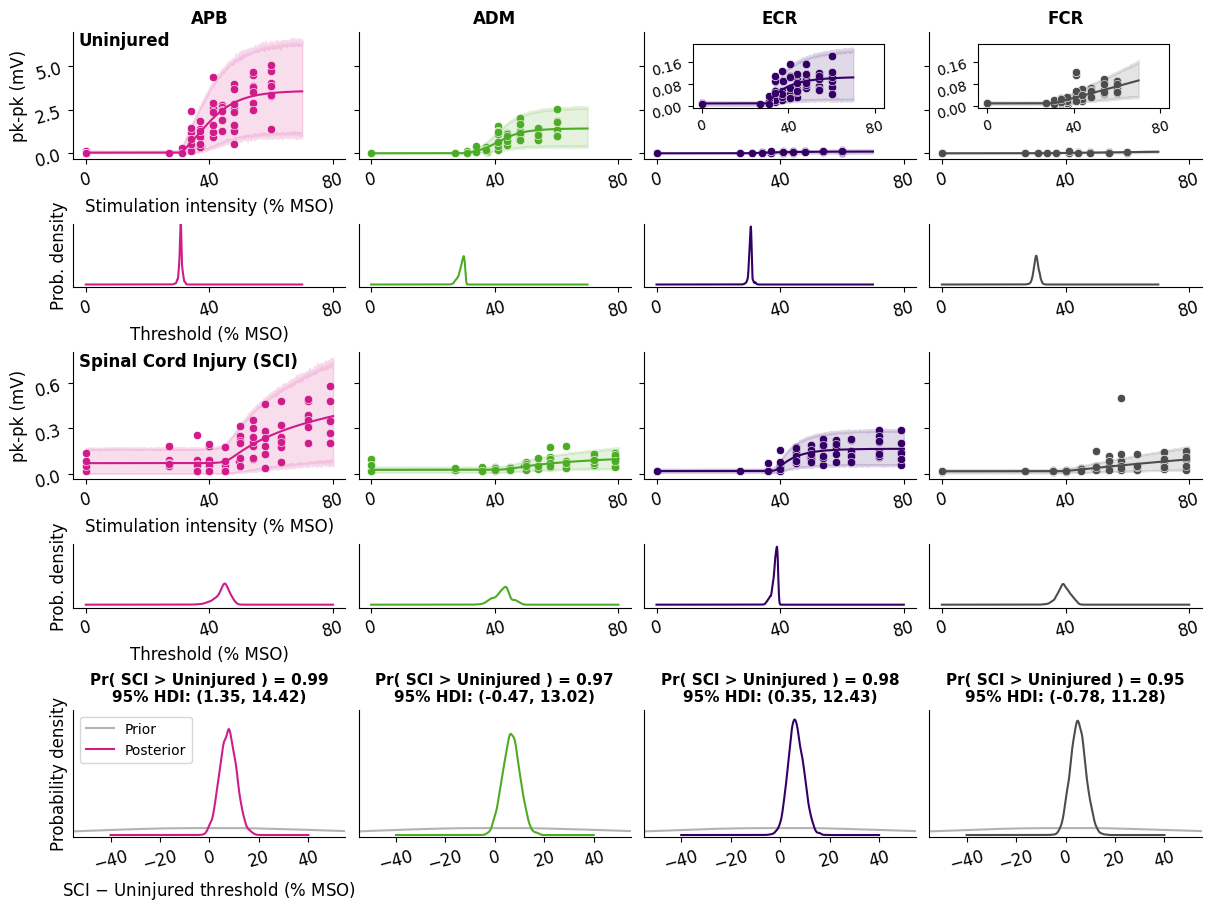

In [11]:
# example_uninjured = ("SCA15", "Uninjured")
example_uninjured = ("SCA06", "Uninjured")

example_sci = ("SCS08", "SCI")
# example_sci = ("SCS06", "SCI")

# example_sci = ("SCS09", "SCI")
# example_sci = ("SCS01", "SCI")

example_combinations = [combinations_map[example_uninjured], combinations_map[example_sci]]

axis_label_size = 12
inner_text_size = 10
share_response_ind = 0

""" Plot """
nrows, ncols = 5, model.n_response
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(3 * ncols, 1.8 * nrows),
    squeeze=False,
    height_ratios=[1, .5, 1, .5, 1],
    constrained_layout=True,
)

rec_ins = {0: [], 1: []}

for muscle_ind in range(model.n_response):
    color = response_colors[muscle_ind]

    for c_counter, c in enumerate(example_combinations):
        ind = df[model.features].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, muscle_ind]
        temp_mu = mu[:, pred_ind, muscle_ind]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

        ax = axes[2 * c_counter, muscle_ind]
        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ax, color=color)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ax)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=color,
            alpha=.15
        )

        if c_counter == 0 and muscle_ind in [2, 3]:
            ins = ax.inset_axes([0.18,0.4,0.7 ,0.5])
            rec_ins[c_counter].append(ins)
            sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ins, color=color)
            sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ins)
            ins.fill_between(
                temp_pred_df[model.intensity],
                temp_obs_hpdi[0, :],
                temp_obs_hpdi[1, :],
                color=color,
                alpha=.15
            )
            ins.set_xlabel("")
            ins.set_ylabel("")
            ins.xaxis.set_major_locator(plt.MaxNLocator(3))
            ins.yaxis.set_major_locator(plt.MaxNLocator(3))
            ins.tick_params(
                axis='both',
                which='both',
                left=True,
                bottom=True,
                right=False,
                top=False,
                labelleft=True,
                labelbottom=True,
                labelright=False,
                labeltop=False,
                labelrotation=15,
                labelsize=10
            )

        ax = axes[2 * c_counter + 1, muscle_ind]
        samples = a[:, *c, muscle_ind]
        kde = stats.gaussian_kde(samples)
        x_grid = temp_pred_df[model.intensity].unique()
        density = kde(x_grid)
        ax.plot(x_grid, density, color=color)

    ax = axes[4, muscle_ind]
    d = dist.Normal(0, 50)
    prior = d.sample(model.rng_key, (10000, ))
    sns.kdeplot(prior, ax=ax, color=prior_color, label="Prior")
    samples = a_loc[:, 0, muscle_ind] - a_loc[:, 1, muscle_ind]
    x_grid = np.linspace(-40, 40, 5000)
    kde = stats.gaussian_kde(samples)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=color, label="Posterior")
    ax.set_xlim(-55, 55)

    prob = (samples > 0).mean()
    ax.set_title(f"Pr( SCI > Uninjured ) = {prob:.2f}\n95% HDI: ({hdi[muscle_ind, 0]:.2f}, {hdi[muscle_ind, 1]:.2f})", fontweight="bold", size=axis_label_size - 1)

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15,
            labelsize=axis_label_size
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

for muscle_ind in range(model.n_response):
    for c_counter, c in enumerate(example_combinations):
        ax = axes[2 * c_counter, muscle_ind]
        if muscle_ind == 0:
            ax.set_xlabel("Stimulation intensity (% MSO)", size=axis_label_size)

        ax = axes[2 * c_counter + 1, muscle_ind]
        if muscle_ind == 0:
            ax.set_xlabel("Threshold (% MSO)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

    ax = axes[4, muscle_ind]
    if muscle_ind == 0:
        ax.set_xlabel("SCI $-$ Uninjured threshold (% MSO)", size=axis_label_size)
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
        labelrotation=15
    )

    ax = axes[0, muscle_ind]
    ax.set_title(model.response[muscle_ind][5:], fontweight="bold", fontsize=axis_label_size)

# Share x-axis
for i in range(0, nrows - 1):
    for j in range(ncols):
        if not i and not j:
            continue
        axes[i, j].sharex(axes[0, 0])

for j in range(ncols):
    axes[-1, j].sharex(axes[-1, 0])

# Share y-axis
for j in range(ncols):
    axes[0, j].sharey(axes[0, share_response_ind])
    axes[1, j].sharey(axes[1, 2])
    axes[2, j].sharey(axes[2, share_response_ind])
    axes[3, j].sharey(axes[3, 2])
    axes[4, j].sharey(axes[4, 0])

ax = axes[0, 0]
ax.tick_params(
    axis='both',
    which='both',
    labelleft=True,
    labelrotation=15
)
ax.set_ylabel("pk-pk (mV)", size=axis_label_size)
ax.set_xticks([0, 40, 80])
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.text(0.02, 1, "Uninjured", fontsize=axis_label_size, va="top", transform=ax.transAxes, fontweight="bold")

ax = axes[1, 0]
ax.set_ylabel("Prob. density", size=axis_label_size)

ax = axes[2, 0]
ax.set_ylabel("pk-pk (mV)", size=axis_label_size)
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    labelleft=True,
)
ax.text(0.02, 1, "Spinal Cord Injury (SCI)", fontsize=axis_label_size, va="top", transform=ax.transAxes, fontweight="bold")

ax = axes[3, 0]
ax.set_ylabel("Prob. density", size=axis_label_size)

ax = axes[4, 0]
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    labelleft=False,
    labelbottom=True,
    labelrotation=15
)
ax.set_ylabel("Probability density", size=axis_label_size)
ax.set_xticks([-40, -20, 0, 20, 40])
ax.legend(loc="upper left", fontsize=inner_text_size)
ax.set_ylim(bottom=-.0025, top=.14)

# Share axes for inset plots
ins = rec_ins[0][0]
ins.sharex(axes[0, 0])
ins.set_xticks([0, 40, 80])
rec_ins[0][1].sharex(ins)
rec_ins[0][1].sharey(ins)

# ax = axes[-1, 0]
# fig.text(1, 0., "HDI: Highest Density Interval", size=axis_label_size, ha="right", va="bottom", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels(axes[[0, 2], :])
fig.align_ylabels(axes[[1, 3, 4], :])

dest = os.path.join(BUILD_DIR, "use_cases_between.svg")
fig.savefig(dest, dpi=600)
dest = os.path.join(BUILD_DIR, "use_cases_between.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved figure to {dest}")
